In [1]:
%cd python

C:\Users\kisha\Documents\LRP_Demo\python


# Notebook to play around the different threshold, digits and methods

In [2]:
import matplotlib.pyplot as plt
import time
import numpy
import numpy as np
import importlib.util as imp
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis

import model_io
import data_io
import render
# import cv2

In [3]:
#load a neural network, as well as the MNIST test data and some labels
nn = model_io.read('../mnist_mlp-Base.txt') # 99.16% prediction accuracy
nn.drop_softmax_output_layer() #drop softnax output layer for analyses

loading plain text model from ../mnist_mlp-Base.txt
removing softmax output mapping


In [4]:
nn_target = model_io.read('../mnist_mlp-DeepTarget.txt') # 99.16% prediction accuracy
nn_target.drop_softmax_output_layer() #drop softnax output layer for analyses

loading plain text model from ../mnist_mlp-DeepTarget.txt
removing softmax output mapping


In [5]:
Xtest_full = data_io.read('../data/MNIST/test_images.npy')
Ytest_full = data_io.read('../data/MNIST/test_labels.npy')

loading np-formatted data from ../data/MNIST/test_images.npy
loading np-formatted data from ../data/MNIST/test_labels.npy


In [6]:
Xtest = []
Ytest = []

for i in range(len(Ytest_full)):
    if Ytest_full[i] in [[5], [6], [7], [8], [9]]:
        Ytest.append(Ytest_full[i])
        Xtest.append(Xtest_full[i])

X = np.array(Xtest)
Y = np.array(Ytest)

In [7]:
# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1

In [8]:
# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y[:,0].astype(int) - 5
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1

In [9]:
acc = np.mean(np.argmax(nn.forward(X), axis=1) == np.argmax(Y, axis=1))
if not np == numpy: # np=cupy
    acc = np.asnumpy(acc)
print('model test accuracy is: {:0.4f}'.format(acc))

model test accuracy is: 0.3868


In [10]:
#permute data order for demonstration. or not. your choice.
I = np.arange(X.shape[0])
#I = np.random.permutation(I)

In [11]:
#Select a Digit between 5-9
digit = 5
for i in I:
  if np.argmax(Y[i])+5 == digit:
    break


In [12]:
#Find Relevance using Base network

x = X[na,i,:]

#forward pass and prediction
ypred = nn.forward(x)
print('True label:     ', np.argmax(Y[i])+5)
print('Predicted label:', np.argmax(ypred),'\n')
print('Prediction Score 0-4', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

R_base = []
#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140
lrp_type = ["simple", "alphabeta", "epsilon", "ww"]
lrp_t = [1, 3, 0.01, 1]
for k in range(len(lrp_type)):
    R_base.append(nn.lrp(Rinit, lrp_type[k], lrp_t[k]))
    
    


#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)
    for k in range(len(lrp_type)):
        R_base[k] = np.asnumpy(R_base[k])

# print(len(R[0]))
#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm_base = []
for k in range(len(lrp_type)):
    hm_base.append(render.hm_to_rgb(R_base[k], X = x, scaling = 3, sigma = 2))
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# # display the image as written to file
# plt.imshow(hm_base, interpolation = 'none')
# plt.axis('off')
# plt.show()

True label:      5
Predicted label: 4 

Prediction Score 0-4 [[-4.09072013 -2.24868486  3.66833004 -1.23474464  6.28628857]]


In [13]:
#Find Relevance using Target network

x = X[na,i,:]

#forward pass and prediction
ypred = nn_target.forward(x)
print('True label:     ', np.argmax(Y[i])+5)
print('Predicted label:', np.argmax(ypred)+5,'\n')
print('Prediction Score 5-9', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
# R_target_0 = nn_target.lrp(Rinit,'simple', 3, reset=0)    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140
# print(R_target)
# print(max(R_target[0]), min(R_target[0]))
reset_values = [0, 1, 2]
R_target = {"simple":[], "alphabeta":[], "epsilon":[], "ww":[], "flat":[]}
for k in range(len(lrp_type)):
    for j in range(len(reset_values)):
        R_target[lrp_type[k]].append(nn_target.lrp(Rinit, lrp_type[k], 3, reset_values[j], t_A=10, t_R=10))
        
        

#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)

#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm_target = {"simple":[], "alphabeta":[], "epsilon":[], "ww":[], "flat":[]}
for k in range(len(lrp_type)):
    for j in range(len(reset_values)):
        hm_target[lrp_type[k]].append(render.hm_to_rgb(R_target[lrp_type[k]][j], X = x, scaling = 3, sigma = 2))
        
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# #display the image as written to file
# plt.imshow(hm_target, interpolation = 'none')
# plt.axis('off')
# plt.show()

True label:      5
Predicted label: 5 

Prediction Score 5-9 [[ 4.95506477  3.142649   -5.96181924 -1.95765397  0.26490566]]


In [14]:
for i in range(len(lrp_type)):
    R_base[i] = R_base[i][0]

for i in range(len(lrp_type)):
    for j in range(len(reset_values)):
        R_target[lrp_type[i]][j] = R_target[lrp_type[i]][j][0]

In [21]:
# Overlap Image
# r, g, b = cv2.split(hm)
# r2, g2, b2 = cv2.split(hm_target)

# t = 0.7

# threshold1 = max(R) * t
# threshold2 = max(R_target) * t


# #Dynamic threshold
# tmp = np.where(R > 0.1)
# threshold1 = np.mean(R[tmp])

# tmp = np.where(R_target > 0.1)
# threshold2 = np.mean(R_target[tmp])

#Top how many percent
t = 10

hm_overlap = []
for i in range(len(lrp_type)):
    for j in range(len(reset_values)):
        target = int(784 - 7.84*t)
        threshold1 = np.partition(R_base[i], target)[target]
        threshold2 = np.partition(R_target[lrp_type[i]][j], target)[target]

        indices1 = np.where(R_base[i] > threshold1)

        indices2 = np.where(R_target[lrp_type[i]][j] > threshold2)


        common_red = np.intersect1d(indices1, indices2)
        
        R_overlap = np.zeros(784)
        R_overlap[common_red] = 10 


        target = int(7.84*t)
        threshold1 = np.partition(R_base[i], target)[target]
        threshold2 = np.partition(R_target[lrp_type[i]][j], target)[target]

        indices1 = np.where(R_base[i] < threshold1)

        indices2 = np.where(R_target[lrp_type[i]] < threshold2)

        common_blue = np.intersect1d(indices1, indices2)
        
        R_overlap[common_blue] = -10 

        hm = render.hm_to_rgb(R_overlap, X = x, scaling = 3, sigma = 2)
        hm_overlap.append(hm)
        
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# #display the image as written to file
# plt.imshow(hm_overlap, interpolation = 'none')
# plt.axis('off')
# plt.show()

# plt.imshow(r2, interpolation = 'none')
# plt.axis('off')
# plt.show()


Order is as follows - 
BaseImage, TargetImage, OverlapImage
Reset = 0
Reset = 1
Reset = 2


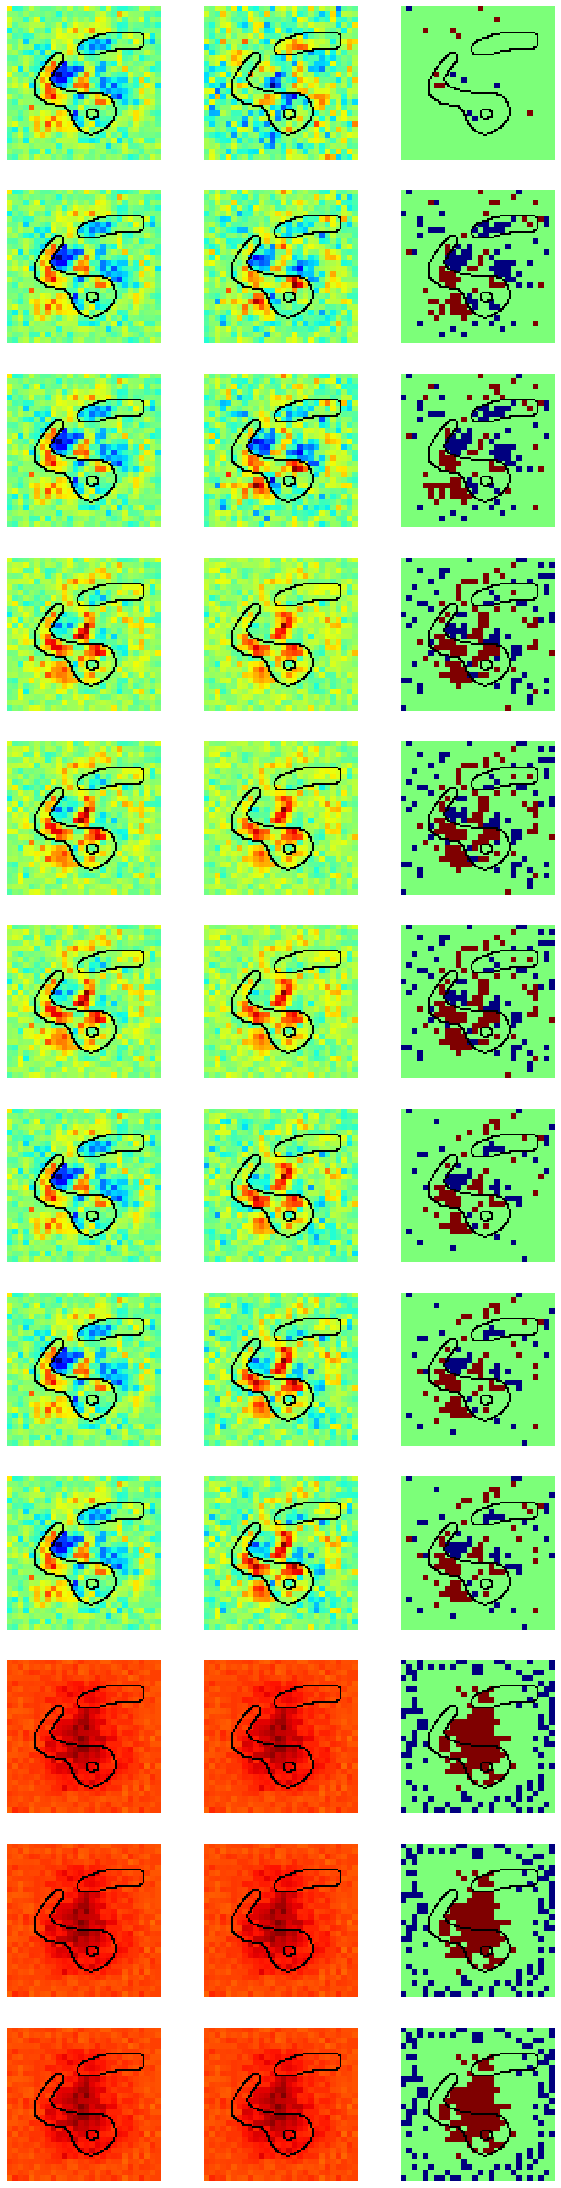

In [20]:

fig, grid = plt.subplots(12, 3, figsize=(10,40)) 
print("Order is as follows - ")
print("BaseImage, TargetImage, OverlapImage")
print("Reset = 0")
print("Reset = 1")
print("Reset = 2")

for i in range(len(lrp_type)*3):
    for j in range(3):
        if(j==0):
            image = hm_base[int(i/3)]
        elif(j==2):
            image = hm_overlap[i]
        else:
            image = hm_target[lrp_type[int(i/3)]][i%3]
            
        grid[i, j].imshow(image)
        grid[i, j].axis('off')
